In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [3]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 10 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 100
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.05
    manifold          = 0.07
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 70
    num_epochs        = 70
    
    num_networks      = 6
    

In [4]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 10
    activation        = 'relu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 100
    num_epochs        = 100

In [5]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [6]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



2022-04-21 09:53:58.235456: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 09:53:58.264004: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2593550000 Hz
2022-04-21 09:53:58.265931: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x565232748070 executing computations on platform Host. Devices:
2022-04-21 09:53:58.265973: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-04-21 09:53:58.268147: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Beginning Training
            Epoch 0            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Model: "fc_layerwise_new"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  110       
_________________________________________________________________
upsampling_layer (Dense)     multiple                  140       
_________________________________________________________________
classification_layer (Dense) multiple                  11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 4.23

Training Set: Los

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.45

Training Set: Loss: 4.162e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.530

Previous Layer Relative # of 0s: 0.0000000

            Epoch 15            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 4.52

Training Set: Loss: 4.171e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.524

Previous Layer Relative # of 0s: 0.0000000

            Epoch 16            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.05
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.37

Training Set: Loss: 4.160e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.530

Previous Layer Relative # of 0s: 0.0000000

            Epoch 31            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 5.32

Training Set: Loss: 4.159e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.523

Previous Layer Relative # of 0s: 0.0000000

            Epoch 32            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.58

Training Set: Loss: 4.163e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.523

Previous Layer Relative # of 0s: 0.0000000

            Epoch 47            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.55

Training Set: Loss: 4.161e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.524

Previous Layer Relative # of 0s: 0.0000000

            Epoch 48            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.06
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.70

Training Set: Loss: 4.160e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.523

Previous Layer Relative # of 0s: 0.0000000

            Epoch 63            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.05
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.73

Training Set: Loss: 4.163e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.523

Previous Layer Relative # of 0s: 0.0000000

            Epoch 64            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.05
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.75

Training Set: Loss: 4.163e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.523

Previous Layer Relative # of 0s: 0.0000000

            Epoch 79            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.08
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 4.03

Training Set: Loss: 4.158e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.524

Previous Layer Relative # of 0s: 0.0000000

            Epoch 80            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.08
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10

ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 11.84

Training Set: Loss: 4.159e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.529

Previous Layer Relative # of 0s: 0.0000000

            Epoch 95            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.05
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 10, 1])
Time per Epoch: 3.65

Training Set: Loss: 4.179e+00, Accuracy: 0.000
Validation Set: Loss: 0.000e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 10.540

Previous Layer Relative # of 0s: 0.0000000

            Epoch 96            
Abalone_FC_L1_mhl10_hl100_rpt05_nTOL4_eTOL4_b70_e70
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 6 batches of size 100:
Time per Batch: 0.05
ListWrapper([13, 10, 10, 1])
ListWrapper([13, 10, 1

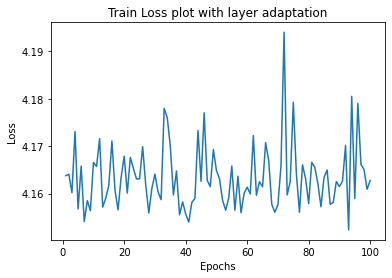

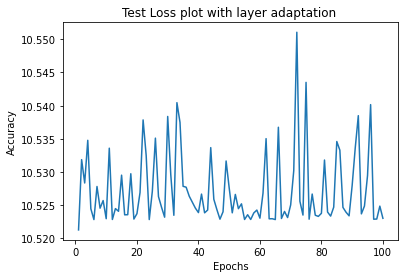

In [7]:
if __name__ == "__main__":     

    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    


    
    #for i in range(1,hyperp.num_networks):
    for i in range(3,4):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
            NN._set_inputs( data_train)
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize_step(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply)   
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        

        
        
        
        
        
        
        
        

In [13]:
hyperp = Hyperparameters()
hyperp_new=Hyperparameters_new()
run_options = RunOptions()
    

    #=== File Names ===#
file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
data_train, labels_train,\
data_test, labels_test,\
data_input_shape, num_channels, label_dimensions= load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 

data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,11)
        

ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(5, activation='elu', input_shape=(13,)))
model.add(layers.Dense(5, activation='elu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
model.fit(data_train,new_label,batch_size=100,epochs=500,verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 70        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
Train on 354 samples
Epoch 1/500
354/354 [==============================] - 1s 2ms/sample - loss: 1.8459 - mean_squared_error: 1.8459
Epoch 2/500
354/354 [==============================] - 0s 25us/sample - loss: 1.5191 - mean_squared_error: 1.5191
Epoch 3/500
354/354 [==============================] - 0s 25us/sample - loss: 1.4262 - mean_squared_error: 1.4262
Epoch 4/500
354/354 [===

354/354 [==============================] - 0s 22us/sample - loss: 1.3076 - mean_squared_error: 1.3076
Epoch 136/500
354/354 [==============================] - 0s 23us/sample - loss: 1.3131 - mean_squared_error: 1.3131
Epoch 137/500
354/354 [==============================] - 0s 27us/sample - loss: 1.3053 - mean_squared_error: 1.3053
Epoch 138/500
354/354 [==============================] - 0s 24us/sample - loss: 1.3053 - mean_squared_error: 1.3053
Epoch 139/500
354/354 [==============================] - 0s 23us/sample - loss: 1.3061 - mean_squared_error: 1.3061
Epoch 140/500
354/354 [==============================] - 0s 22us/sample - loss: 1.3069 - mean_squared_error: 1.3069
Epoch 141/500
354/354 [==============================] - 0s 22us/sample - loss: 1.3063 - mean_squared_error: 1.3063
Epoch 142/500
354/354 [==============================] - 0s 21us/sample - loss: 1.3029 - mean_squared_error: 1.3029
Epoch 143/500
354/354 [==============================] - 0s 22us/sample - loss: 1.3073

354/354 [==============================] - 0s 24us/sample - loss: 1.2671 - mean_squared_error: 1.2671
Epoch 276/500
354/354 [==============================] - 0s 22us/sample - loss: 1.2654 - mean_squared_error: 1.2654
Epoch 277/500
354/354 [==============================] - 0s 23us/sample - loss: 1.2687 - mean_squared_error: 1.2687
Epoch 278/500
354/354 [==============================] - 0s 27us/sample - loss: 1.2680 - mean_squared_error: 1.2680
Epoch 279/500
354/354 [==============================] - 0s 25us/sample - loss: 1.2658 - mean_squared_error: 1.2658
Epoch 280/500
354/354 [==============================] - 0s 25us/sample - loss: 1.2689 - mean_squared_error: 1.2689
Epoch 281/500
354/354 [==============================] - 0s 24us/sample - loss: 1.2673 - mean_squared_error: 1.2673
Epoch 282/500
354/354 [==============================] - 0s 28us/sample - loss: 1.2655 - mean_squared_error: 1.2655
Epoch 283/500
354/354 [==============================] - 0s 26us/sample - loss: 1.2630

354/354 [==============================] - 0s 31us/sample - loss: 1.2010 - mean_squared_error: 1.2010
Epoch 416/500
354/354 [==============================] - 0s 27us/sample - loss: 1.2001 - mean_squared_error: 1.2001
Epoch 417/500
354/354 [==============================] - 0s 27us/sample - loss: 1.2060 - mean_squared_error: 1.2060
Epoch 418/500
354/354 [==============================] - 0s 28us/sample - loss: 1.1960 - mean_squared_error: 1.1960
Epoch 419/500
354/354 [==============================] - 0s 28us/sample - loss: 1.1948 - mean_squared_error: 1.1948
Epoch 420/500
354/354 [==============================] - 0s 29us/sample - loss: 1.1928 - mean_squared_error: 1.1928
Epoch 421/500
354/354 [==============================] - 0s 26us/sample - loss: 1.1957 - mean_squared_error: 1.1957
Epoch 422/500
354/354 [==============================] - 0s 31us/sample - loss: 1.1938 - mean_squared_error: 1.1938
Epoch 423/500
354/354 [==============================] - 0s 30us/sample - loss: 1.1962

In [12]:
model.save("WEIGHTS"+'/'+"model"+str(10))
batch_pred_test = model(data_test)
y_pred_test_add=net_output(hyperp,hyperp_new,data_test, run_options, data_input_shape, label_dimensions,10,batch_pred_test)
batch_pred_test=batch_pred_test+y_pred_test_add
mean_accuracy_test = tf.keras.metrics.Mean()
mean_accuracy_test(data_loss_regression(batch_pred_test, labels_test,label_dimensions))

INFO:tensorflow:Assets written to: WEIGHTS/model10/assets
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])
ListWrapper([13, 5, 5, 1])


<tf.Tensor: id=37243, shape=(), dtype=float32, numpy=13.42871>

In [17]:
mean_accuracy_test = tf.keras.metrics.Mean()
mean_accuracy_test(data_loss_regression(batch_pred_test, labels_test,label_dimensions))

<tf.Tensor: id=8433, shape=(), dtype=float32, numpy=13.233284>

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: WEIGHTS/model9/assets


SyntaxError: can't assign to operator (<ipython-input-30-baf321f0c7a6>, line 1)

In [25]:
"WEIGHTS"+'/'+"model_weights"+str(i_val)
hidden_layers_list.insert(0, NoDependency(1))        


In [29]:
hidden_layers_list[0]

TypeError: 'NoDependency' object does not support indexing

In [11]:
hidden_layers_list

[1]

In [12]:
len(hidden_layers_list)

1

In [10]:
            Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(2-1)).expect_partial()
    
            y_pred=Network(data_train)


ListWrapper([13, 100, 100, 1])


In [11]:
new_label=tf.reshape(new_label,(len(y_pred),1))

In [38]:
y_pred

<tf.Tensor: id=1459128, shape=(354, 1), dtype=float32, numpy=
array([[33.76945  ],
       [26.26653  ],
       [27.390202 ],
       [16.94542  ],
       [17.081976 ],
       [32.343895 ],
       [27.67299  ],
       [24.495663 ],
       [22.398619 ],
       [26.520485 ],
       [35.224224 ],
       [-2.244073 ],
       [ 6.259705 ],
       [38.08592  ],
       [17.74724  ],
       [32.85308  ],
       [24.74735  ],
       [ 8.830112 ],
       [31.070496 ],
       [24.71079  ],
       [30.053083 ],
       [30.796227 ],
       [35.541714 ],
       [32.961033 ],
       [21.649975 ],
       [28.837845 ],
       [21.118425 ],
       [22.64952  ],
       [29.759092 ],
       [26.474918 ],
       [34.143085 ],
       [27.279566 ],
       [22.111225 ],
       [32.622135 ],
       [32.75378  ],
       [21.810385 ],
       [30.475466 ],
       [25.062466 ],
       [31.382488 ],
       [20.840607 ],
       [ 6.8198676],
       [26.091671 ],
       [13.0004635],
       [ 9.380229 ],
       [ 4.024

In [37]:
new_label

<tf.Tensor: id=1459150, shape=(354, 1), dtype=float32, numpy=
array([[35.2],
       [25. ],
       [36.2],
       [16.1],
       [10.9],
       [36.4],
       [25. ],
       [20.1],
       [16.8],
       [23.7],
       [42.3],
       [17.9],
       [12.7],
       [50. ],
       [18.4],
       [33.4],
       [22.9],
       [14.6],
       [29.9],
       [22.6],
       [22.5],
       [29. ],
       [50. ],
       [37.9],
       [21.4],
       [29.4],
       [20.3],
       [23. ],
       [30.1],
       [21.7],
       [36.5],
       [25. ],
       [24.5],
       [37.3],
       [33.8],
       [24.7],
       [32.7],
       [23.1],
       [25.1],
       [21.7],
       [13.4],
       [24.8],
       [12.7],
       [11.8],
       [ 8.3],
       [20.2],
       [41.3],
       [23.2],
       [23.1],
       [24.3],
       [19.3],
       [10.8],
       [18.6],
       [29. ],
       [23.9],
       [19.5],
       [13.1],
       [31.7],
       [21. ],
       [18.2],
       [21. ],
       [21.2],
       [

In [12]:
np.multiply(new_label,y_pred)

array([[1188.6847  ],
       [ 656.6632  ],
       [ 991.5253  ],
       [ 272.82126 ],
       [ 186.19353 ],
       [1177.3179  ],
       [ 691.82477 ],
       [ 492.36282 ],
       [ 376.29678 ],
       [ 628.5355  ],
       [1489.9846  ],
       [ -40.168903],
       [  79.49825 ],
       [1904.2959  ],
       [ 326.54922 ],
       [1097.293   ],
       [ 566.7143  ],
       [ 128.91965 ],
       [ 929.0078  ],
       [ 558.46387 ],
       [ 676.1944  ],
       [ 893.0906  ],
       [1777.0857  ],
       [1249.2231  ],
       [ 463.30945 ],
       [ 847.83264 ],
       [ 428.704   ],
       [ 520.93896 ],
       [ 895.7487  ],
       [ 574.50574 ],
       [1246.2227  ],
       [ 681.98914 ],
       [ 541.72504 ],
       [1216.8057  ],
       [1107.0778  ],
       [ 538.7165  ],
       [ 996.5477  ],
       [ 578.943   ],
       [ 787.70044 ],
       [ 452.24118 ],
       [  91.38622 ],
       [ 647.0734  ],
       [ 165.10588 ],
       [ 110.68671 ],
       [  33.401306],
       [ 4

In [15]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
            
data_and_labels_train_new_new = ff.batch(batch_size)
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

In [19]:
x_train_new = batch_data_train[batch_labels_train == 1]


In [21]:
batch_pred_train,val=NN(x_train_new)
dimension=np.shape(val)
        

length=len(x_train_new)

In [26]:
new_one=val[1:length]

In [29]:
sum_val = 0.1*length*dimension[1]*tf.math.reduce_mean(tf.keras.losses.mean_squared_error(new_one, val[0:length-1]))

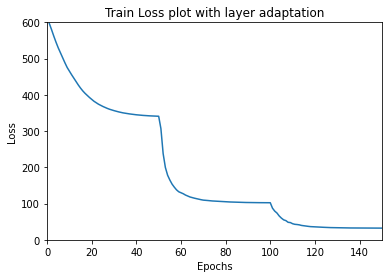

In [16]:
    import matplotlib.pyplot as plt
    storage_loss_array=[]
    storage_accuracy_array=[]
    max_hidden_layers=7
    no_epoch=hyperp.num_epochs
    
    for i in range(2,max_hidden_layers):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
 
        storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
    if not os.path.exists("plots"):
        os.makedirs("plots")
#=== Plot and Save Losses===#
    fig_loss = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_accuracy_array), endpoint = True)
    plt.plot(x_axis, storage_loss_array)
    plt.title('Train Loss plot with layer adaptation' )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,600)
    plt.xlim(0,150)
    fig_loss.savefig("plots"+'/'+"loss"+str(1)+'.png')


In [20]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,new_label)).shuffle(num_data_train, seed=random_seed)

array([[0.35918419, 0.28422403, 0.10307025, ..., 0.        , 0.        ,
        0.62466817],
       [0.32605052, 0.24233485, 0.08812176, ..., 0.88121761, 0.        ,
        0.        ],
       [0.29166546, 0.22884521, 0.07628174, ..., 0.44871611, 0.        ,
        0.        ],
       ...,
       [0.2655331 , 0.20324756, 0.0721201 , ..., 0.        , 0.65563727,
        0.        ],
       [0.28990458, 0.23060589, 0.07906488, ..., 0.43924934, 0.        ,
        0.        ],
       [0.34885539, 0.26677175, 0.09850034, ..., 0.        , 0.        ,
        0.82083619]])

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets
kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
(data_train, labels_train), (data_test, labels_test) = datasets.cifar10.load_data()
#(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
#data_train = tf.reshape(data_train, (len(data_train), 28*28))
#data_test = tf.reshape(data_test, (len(data_test), 28*28))
data_train = tf.reshape(data_train, (len(data_train), 32*32*3))
data_test = tf.reshape(data_test, (len(data_test), 32*32*3))
    
label_dimensions = 10
data_input_shape = data_train.shape[1:]

In [28]:
labels_train=np.squeeze(labels_train,axis=1)

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [8]:
Network=Final_Network(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer) 

ListWrapper([28, 10, 10, 10])


In [9]:
Network.load_weights("WEIGHTS"+'/'+"model_weights1")

In [10]:
num_data_train = len(data_train)
data_and_labels_train_new = data_and_labels_train_full.take(num_data_train)

NameError: name 'data_and_labels_train_full' is not defined

In [9]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
batch_size=100           
data_and_labels_train_new_new = ff.batch(batch_size)

NameError: name 'random_seed' is not defined

In [8]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

NameError: name 'data_and_labels_train_new_new' is not defined

In [35]:
x_train_new = batch_data_train[batch_labels_train == 0]

<tf.Tensor: id=257704, shape=(8, 10), dtype=float64, numpy=
array([[0.3567994 , 0.28774145, 0.08440416, 0.38365526, 0.16113521,
        0.08670609, 0.11548023, 0.        , 0.        , 0.76731053],
       [0.29701502, 0.23368094, 0.08080556, 0.70191636, 0.31645203,
        0.14042695, 0.21751982, 0.        , 0.        , 0.43678679],
       [0.34182954, 0.26751877, 0.09809022, 0.5739764 , 0.29605411,
        0.11295237, 0.13673182, 0.        , 0.        , 0.59448617],
       [0.31044639, 0.24704538, 0.08744969, 0.70003475, 0.3086974 ,
        0.14035676, 0.1967618 , 0.        , 0.        , 0.43724845],
       [0.28379031, 0.22466732, 0.07883064, 0.72031496, 0.3622268 ,
        0.14426007, 0.1911643 , 0.        , 0.        , 0.39415319],
       [0.33470906, 0.26276223, 0.10322803, 0.57526161, 0.20989698,
        0.12418644, 0.16266233, 0.        , 0.        , 0.62562438],
       [0.3415542 , 0.25898065, 0.11260029, 0.43501245, 0.12648766,
        0.09383357, 0.16139374, 0.        , 0.    

In [10]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(batch_size)
num_batches_test = len(list(data_and_labels_test))

#=== Partitioning Out Validation Set and Constructing Batches ===#
current_num_data_train = num_data_train
num_data_train = int(0.8 * num_data_train)
num_data_val = current_num_data_train - num_data_train
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [23]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

In [24]:
labels=tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [25]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,labels)).shuffle(num_data_train, seed=random_seed)

In [26]:
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [32]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    batch=batch_num
    batch_data_train = batch_data_train
    batch_labels_train=batch_labels_train
    lab=labels

In [36]:
lab


<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
y_true = tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [21]:
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [37]:
np.mean(tf.keras.losses.mean_squared_error(new_one, val[0:dimension[0]-1]))

1.9269863

array([4, 6, 6, ..., 7, 2, 5])

In [19]:

x_train_new = batch_data_train[batch_labels_train == 1]
batch_pred_train,val=NN(x_train_new)



In [16]:
y_true = tf.one_hot(tf.cast(y_true,tf.int64), label_dimensions, dtype=tf.float32)

In [45]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.6097095>

In [48]:
np.linalg.norm(val[0]-val[1])

2.567157